# Zooming into a Figure with Matplotlib/Seaborn
### Illustrated with the Example of Population Density of German Zip-Codes

Get the `plz_einwohner.csv` from: https://www.suche-postleitzahl.org/downloads#google_vignette

To set up a clean environment with all the required dependencies without installing them on your machine run:
```
python3 -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

Import the required modules

In [208]:
# for the data and plotting
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# for the zooming
from PIL import Image
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

Read file into Pandas dataframe and view first rows

In [182]:
df = pd.read_csv("plz_einwohner.csv", dtype={"plz": str})
df.head()

,plz,note,einwohner,qkm,lat,lon
0,01067,01067 Dresden,11957,6.866862,51.06019,13.71117
1,01069,01069 Dresden,25491,5.351816,51.03964,13.73030
2,01097,01097 Dresden,14821,3.297752,51.06945,13.73781
3,01099,01099 Dresden,28018,58.506789,51.09272,13.82842
4,01108,01108 Dresden,5876,16.447222,51.15180,13.79227


Calculate population density

In [ ]:
# only plzs with more than 500 inhabitants (using deep copy to surpress a warning)
df_selected = df.loc[df["einwohner"]>500].copy(deep=True)

# to calculate population density for each zip code we simply divide the number of inhabitants by the area (let's also cast the result into an integer so we get rid of the decimals)
df_selected["dichte"] = df_selected["einwohner"].div(df_selected["qkm"]).astype(int)
df_selected.head()

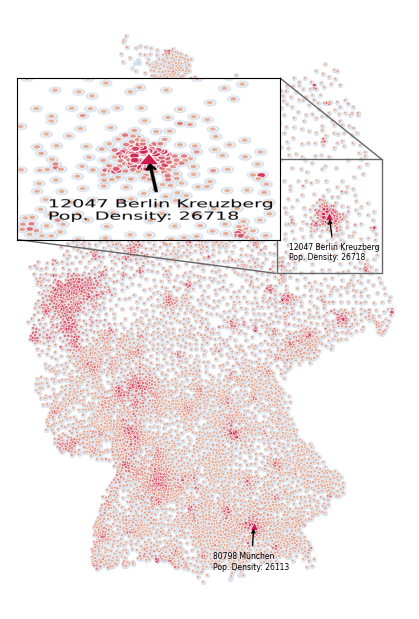

In [243]:
# let's start off by initiating our figure / canvas
ratio = (4, 6)
fig = plt.figure(frameon=True)
fig.set_size_inches(*ratio)
axes = plt.Axes(fig, [0, 0, 1, 1])
axes.set_axis_off() # I like to disable the axis for this plot to make it look more pretty
fig.add_axes(axes)

# lets plot ourselves a little background with ALL zip codes to see what we are actually dealing with here
sns.scatterplot(ax=axes, x=df['lon'], y=df['lat'], s=15, color='lightsteelblue', alpha=.5, marker='o')

# For a nice gradient hue in the colors of the markers I like to define the colors of the two extremes (lowest and highest) and let the script calculate the colors for everything in between
color_lowest = (0.9, 0.7, 0.6) # this is orange
color_highest = (0.8, 0.1, 0.3) # this is red

r = np.linspace(color_lowest[0], color_highest[0], num=len(df_selected["dichte"].unique()))
g = np.linspace(color_lowest[1], color_highest[1], num=len(df_selected["dichte"].unique()))
b = np.linspace(color_lowest[2], color_highest[2], num=len(df_selected["dichte"].unique()))

cust_palette = [item for item in zip(r,g,b)]

# let's plot the population density over our previous plot and use our custom color palette
sns.scatterplot(ax=axes, x=df_selected['lon'], y=df_selected['lat'], size=abs(df_selected["dichte"]), alpha=1, marker='.', hue=abs(df_selected["dichte"]), palette=cust_palette, legend=False)

# select two highest density plzs
df_top = df_selected.sort_values("dichte", ascending=False).head(2)
sns.scatterplot(ax=axes, x=df_top['lon'], y=df_top['lat'], alpha=1, marker='^', color=color_highest, legend=False)

# annotate the two highest density plzs
for i in range(len(df_top)):
    row = df_top.iloc[i]
    xy = (row.lon, row.lat)
    # let's safe the highest values for later
    if i == 0:
        xy_top = xy
    axes.annotate(f"{row.note}\nPop. Density: {row.dichte}", xy=xy, xytext=(xy[0]-1, xy[1]-.6), fontsize=5.5, arrowprops=dict(arrowstyle="->", facecolor='black'))

fig.savefig(f"tmp.png", pad_inches=0, dpi=600) # bbox_inches='tight'

# now for the actual zooming
# let's define how large our zooming area will be - this was trial and error basically to see how much was needed to cover the whole Berlin area
# we know that berlin is a location xy_top (first index contains longitude, second contains latitude)
# now we just add a little padding to get the whole of berlin into the frame
zoomed_lon_range = [xy_top[0]-1.3, xy_top[0]+1.3]
zoomed_lat_range = [xy_top[1]-.8, xy_top[1]+.8]

extent = (zoomed_lon_range[0], zoomed_lon_range[1], zoomed_lat_range[0], zoomed_lat_range[1])

# load in the previously savedimage
img = Image.open(f"tmp.png")
img.load()

# save the image as a multidimensional numpy array / matrix containing ints
data = np.asarray(img, dtype="int32")
# we have to reverse the order of the rows of our matrix as PIL will read it in reverse
data = np.flip(data, axis=0)

# the next part is a little bit tricky but basically we have to compute a factor that let's us convert the old dimension into the new dimension of the loaded image
# so in other words we want a mapping that tells us what the range in the old 
# range of the old figure
lon_range = list(axes.get_xlim()) # [5.535051, 15.429309]
lat_range = list(axes.get_ylim()) # [46.988626999999994, 55.397533]

# the next two lines create vectors with the length of our loaded image data array that contain values ranging within the previously computed longitude, latitude ranges
lon_to_x_idx = np.linspace(lon_range[0], lon_range[1], num=len(data[0]))
lat_to_y_idx = np.linspace(lat_range[0], lat_range[1], num=len(data))

# with these we can easily get the index for the longitude/latitude values of our zoomed frame using the argmin function which gives us the index of the value that is closest to the zoomed value
# the index is just the counterpart/translation of that longitude/latitude in the newly loaded image data array
x_idx_start = np.absolute(lon_to_x_idx-zoomed_lon_range[0]).argmin()
x_idx_end = np.absolute(lon_to_x_idx-zoomed_lon_range[1]).argmin()
# do the same for y / latitude
y_idx_start = np.absolute(lat_to_y_idx-zoomed_lat_range[0]).argmin()
y_idx_end = np.absolute(lat_to_y_idx-zoomed_lat_range[1]).argmin()

# let's configure the zoom with the newly computed values
axins = zoomed_inset_axes(axes, zoom=2.5, loc=2)
axins.imshow(data[y_idx_start:y_idx_end, x_idx_start:x_idx_end, :], extent=extent, origin="lower")

mark_inset(axes, axins, loc1=1, loc2=3, ec=".4")

# to hide axes from zoomed frame
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)